**Задача 2. Сравнение методов классификации**

Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

from sklearn import model_selection
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [2]:
def e_metrics(x1, x2):
    return np.sqrt(np.sum((x2-x1)**2))

Реализуем алгоритм поиска k ближайших соседей.

In [3]:
def knn_(x_train, y_train, x_test, k):
    
    X_train_np=X_train.to_numpy()
    X_test_np=X_test.to_numpy()
    y_train_np=y_train.to_numpy()
    answers = []
    for x in X_test_np:
        test_distances = []
            
        for i in range(len(X_train_np)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, X_train_np[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train_np[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train_np)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

Напишем функцию для вычисления точности

In [4]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Функция для подбора гиперпараметра k для алгоритма knn

In [5]:
def selection_k(x_train, y_train, x_test, k_):
  accur = []
  for k in k_: 
    y_pred = knn_(X_train, y_train, X_test, k)
    acc = accuracy(y_pred, y_test)
    accur.append(acc)
    print(f'Точность алгоритма при k = {k}: {acc:.3f}')
  return max(accur)

Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (Data Cleaning).

Прогнозирования инсульта

* id: уникальный идентификатор
*  пол: "Мужской", "Женский" или "Другой"
*  возраст: возраст пациента
*  гипертония: 0, если у пациента нет гипертонии, 1, если у пациента гипертония
*  heart_disease: 0, если у пациента нет заболеваний сердца, 1, если у пациента есть заболевание сердца
*  ever_married: "Нет" или "Да"
*  work_type: "детский", "государственный", "никогда не работавший", "частный" или "самозанятый"
*  Residence_type: "Сельская" или "Городская"
*  avg_glucose_level: средний уровень глюкозы в крови
*  ИМТ: индекс массы тела
*  smoke_status: "ранее курил", "никогда не курил", "курит" или "неизвестно"*
*  stroke: 1, если у пациента был инсульт или 0, если нет (target)
*Примечание: «Неизвестно» в курении_статуса означает, что информация для этого пациента недоступна.

Необходимо решить задачу классификации и научиться предсказывать целовой признак target имеет ли пациент инсульт.

In [6]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [7]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [8]:
df.shape

(5110, 12)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


In [11]:
df.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

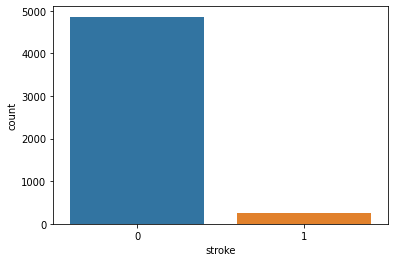

In [12]:
sns.countplot(x="stroke", data=df)
plt.show()

Из данных видно что целевая переменная НЕ сбалансирована. Возможно, при обучении необходимо будет использовать балансировку классов.

In [13]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac19925ed0>,
      dtype=object)

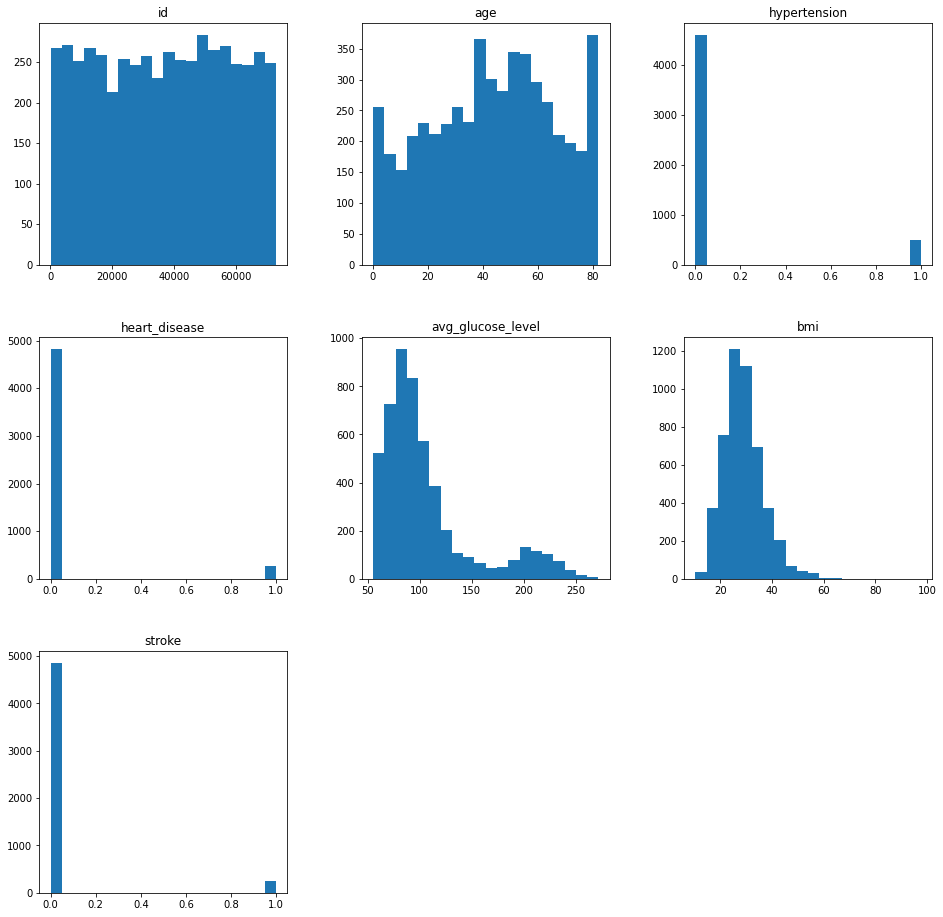

In [14]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False)

In [15]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

gender

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
****************************************************************************************************

ever_married

Yes    3353
No     1757
Name: ever_married, dtype: int64
****************************************************************************************************

work_type

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
****************************************************************************************************

Residence_type

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
****************************************************************************************************

smoking_status

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64
****************************************************************

Из распределения значений категориальных переменных видно что необходимо поработать с признаком "gender".

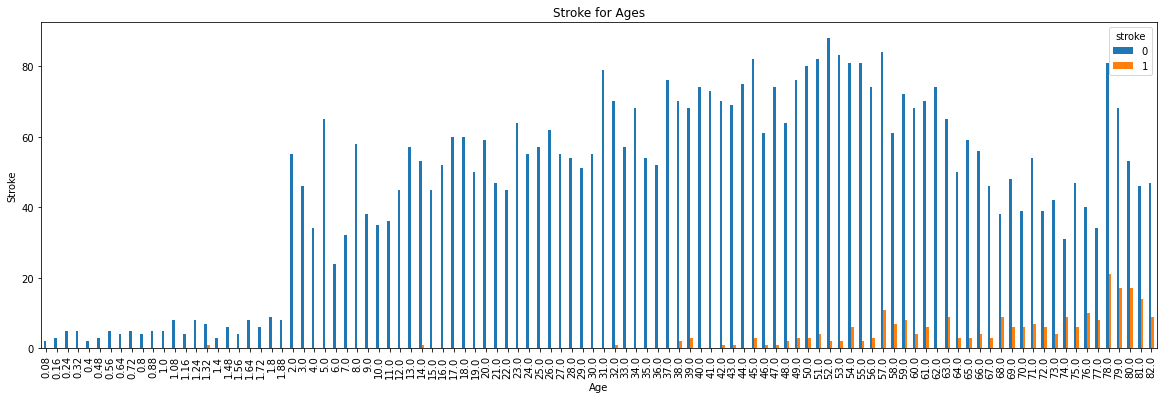

In [17]:
pd.crosstab(df.age,df.stroke).plot(kind="bar", figsize=(20, 6))
plt.title('Stroke for Ages')
plt.xlabel('Age')
plt.ylabel('Stroke')
plt.show()

Гистограмма показывает, как целевая переменная (перенесенный инсульт) зависит от возраста пациента. Можно предположить, что с увеличением возраста вероятность возможности инсульта возрастает.

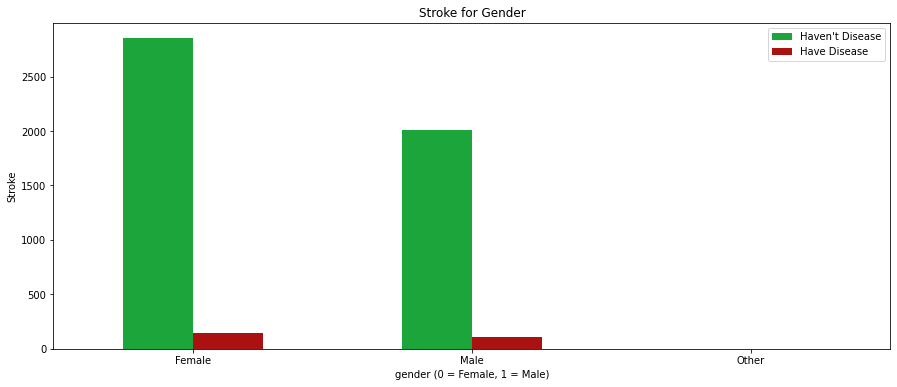

In [24]:
pd.crosstab(df.gender,df.stroke).plot(kind="bar", figsize=(15, 6), color=['#1CA53B', '#AA1111' ])
plt.title('Stroke for Gender')
plt.xlabel('gender (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Stroke')
plt.show()

Гистограмма показывает, что пол пациента не влияет на наличие заболевания. 

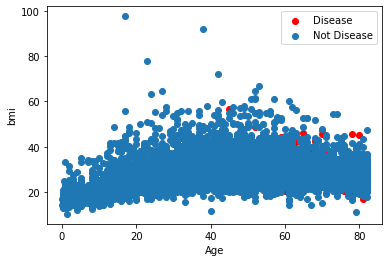

In [26]:
plt.scatter(x=df.age[df.stroke==1], y=df.bmi[(df.stroke==1)], c="red")
plt.scatter(x=df.age[df.stroke==0], y=df.bmi[(df.stroke==0)])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("Age")
plt.ylabel("bmi")
plt.show()

Из графика видно, что уровень индекса массы тела не является однозначным признаком наличия инсульта.

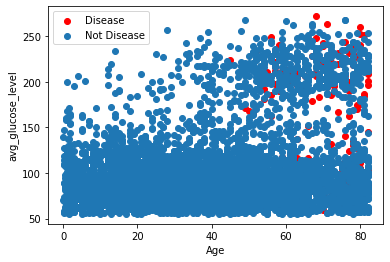

In [27]:
plt.scatter(x=df.age[df.stroke==1], y=df.avg_glucose_level[(df.stroke==1)], c="red")
plt.scatter(x=df.age[df.stroke==0], y=df.avg_glucose_level[(df.stroke==0)])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("Age")
plt.ylabel("avg_glucose_level")
plt.show()

Из графика видно, что уровень глюкозы в крови не является однозначным фактором наличия заболевания.

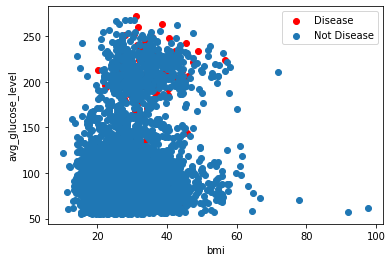

In [28]:
plt.scatter(x=df.bmi[df.stroke==1], y=df.avg_glucose_level[(df.stroke==1)], c="red")
plt.scatter(x=df.bmi[df.stroke==0], y=df.avg_glucose_level[(df.stroke==0)])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("bmi")
plt.ylabel("avg_glucose_level")
plt.show()

Из графика видно что однозначной зависимости между индексом массы тела и уровнем глюкозы нет.

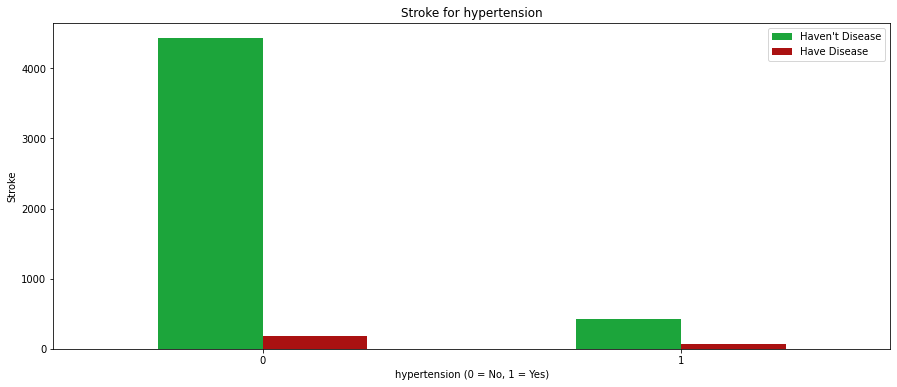

In [29]:
pd.crosstab(df.hypertension,df.stroke).plot(kind="bar", figsize=(15, 6), color=['#1CA53B', '#AA1111' ])
plt.title('Stroke for hypertension')
plt.xlabel('hypertension (0 = No, 1 = Yes)')
plt.xticks(rotation=0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Stroke')
plt.show()

Из графика видно что инсульту подвержены и пациенты с гипертонией, и без нее. Но, вполне возможно, что эти люди в "группе риска".

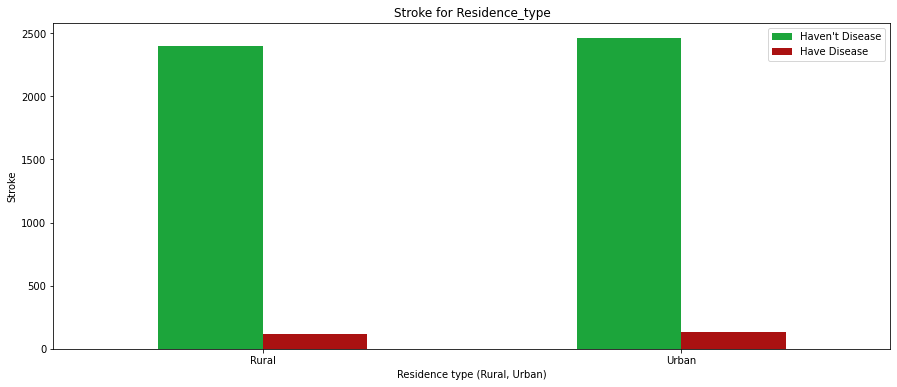

In [30]:
pd.crosstab(df.Residence_type,df.stroke).plot(kind="bar", figsize=(15, 6), color=['#1CA53B', '#AA1111' ])
plt.title('Stroke for Residence_type')
plt.xlabel('Residence type (Rural, Urban)')
plt.xticks(rotation=0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Stroke')
plt.show()

Место жительства не имеет прямой зависимости с фактом наличия инсульта.

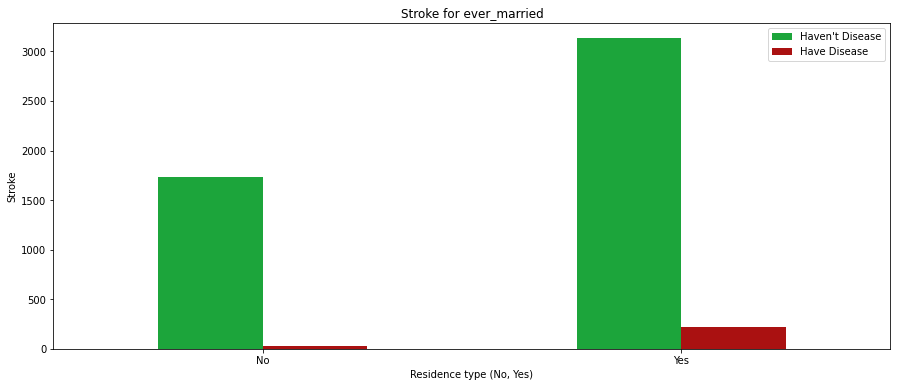

In [31]:
pd.crosstab(df.ever_married,df.stroke).plot(kind="bar", figsize=(15, 6), color=['#1CA53B', '#AA1111' ])
plt.title('Stroke for ever_married')
plt.xlabel('Residence type (No, Yes)')
plt.xticks(rotation=0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Stroke')
plt.show()

Семейное положение также не влияет на целевую переменную.

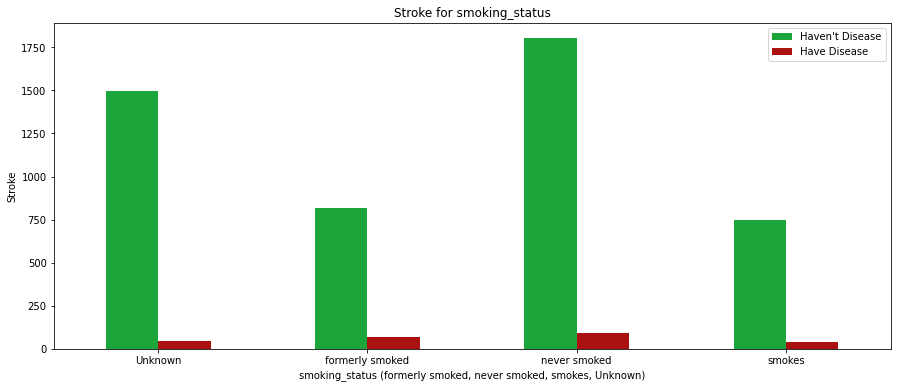

In [32]:
pd.crosstab(df.smoking_status,df.stroke).plot(kind="bar", figsize=(15, 6), color=['#1CA53B', '#AA1111' ])
plt.title('Stroke for smoking_status')
plt.xlabel('smoking_status (formerly smoked, never smoked, smokes, Unknown)')
plt.xticks(rotation=0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Stroke')
plt.show()

Курение(в прошлом и настоящем) может оказывать влияние на факт наличия инсульта.

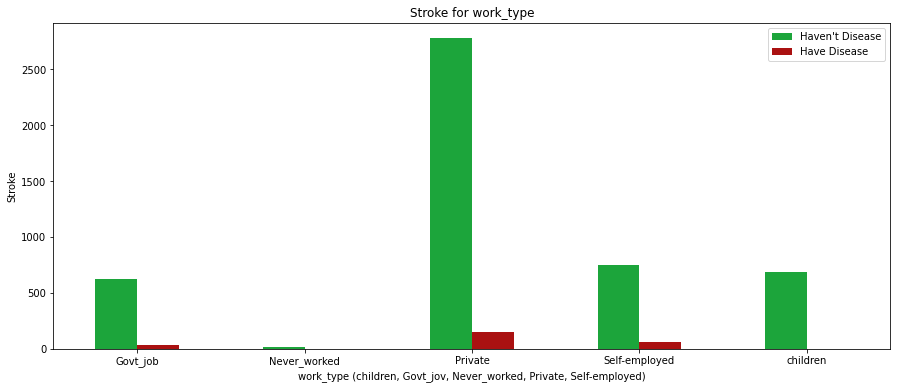

In [33]:
pd.crosstab(df.work_type,df.stroke).plot(kind="bar", figsize=(15, 6), color=['#1CA53B', '#AA1111' ])
plt.title('Stroke for work_type')
plt.xlabel('work_type (children, Govt_jov, Never_worked, Private, Self-employed)')
plt.xticks(rotation=0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Stroke')
plt.show()

Из графика видно что инсульт встречается у осуществляющих какую-либо рабочую деятельность пациентов.

# Замена пропусков

Проверяем общее количество пропущенных значений.

In [34]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Присутствуют пропуски в поле индекса массы тела. Необходимо заполнить пропуски. В данном случае будет использована медиана.

In [48]:
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

In [49]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

#Корреляция признаков

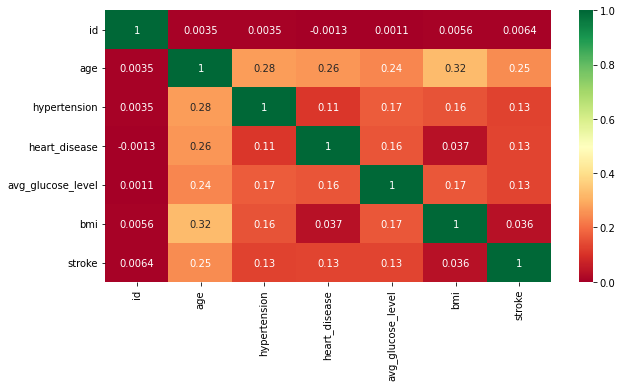

In [50]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

#Feature Engineering

Удаление ненужных признаков

Удалим порядковый номер экземпляра, он не несет никакого смысла в качестве признака для обучения модели.

In [51]:
df.drop(['id'], axis=1, inplace=True)

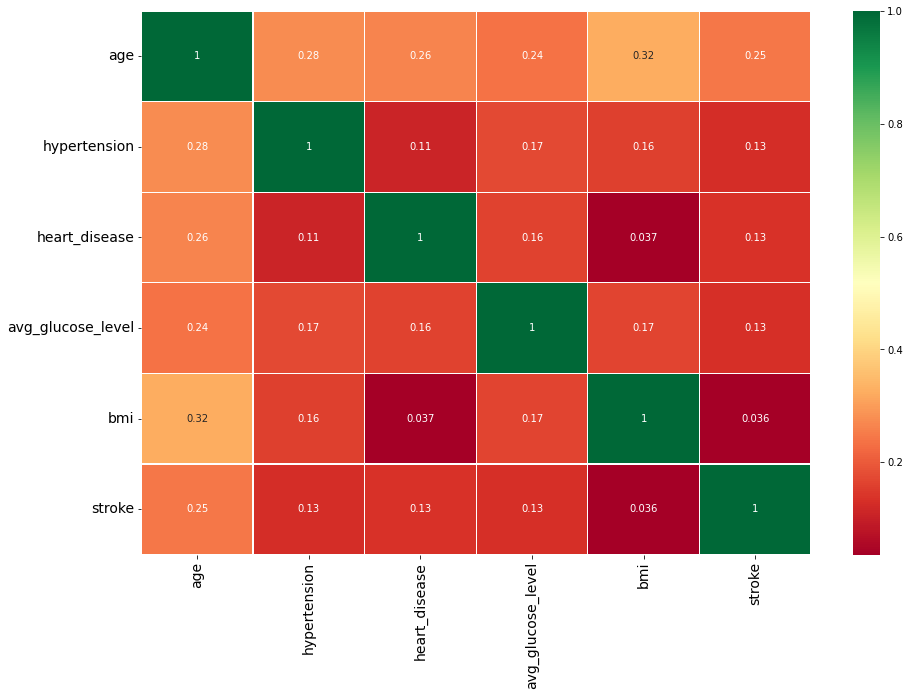

In [52]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2, annot_kws={'size':10})
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

На данный момент в бОльшей части цивилизованного мира деление происходит на 2 гендера. В данном случае можно или удалить этот объект, или отнести его к одному из гендерных классов.

In [53]:
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [56]:
df.loc[df['gender'] == 'Other', 'gender'] = 'Male'
df['gender'].value_counts()

Female    2994
Male      2116
Name: gender, dtype: int64

Преобразование категориальных признаков

Закодируем категориальные признаки gender, ever_married, work_type, Residence_type и smoking_status.

In [57]:
gender_dum = pd.get_dummies(df['gender'], prefix = "gender")
ever_married_dum = pd.get_dummies(df['ever_married'], prefix = "ever_married")
work_type_dum = pd.get_dummies(df['work_type'], prefix = "work_type")
Residence_type_dum = pd.get_dummies(df['Residence_type'], prefix = "Residence_type")
smoking_status_dum = pd.get_dummies(df['smoking_status'], prefix = "smoking_status")

frames = [df, gender_dum, ever_married_dum, work_type_dum, Residence_type_dum, smoking_status_dum]
df = pd.concat(frames, axis = 1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,...,0,1,0,0,0,1,0,1,0,0
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,...,0,0,1,0,1,0,0,0,1,0
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,...,0,1,0,0,1,0,0,0,1,0
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,...,0,1,0,0,0,1,0,0,0,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,...,0,0,1,0,1,0,0,0,1,0


In [58]:
df = df.drop(columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
1,61.0,0,0,202.21,28.1,1,1,0,0,1,...,0,0,1,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.5,1,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0
3,49.0,0,0,171.23,34.4,1,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
4,79.0,1,0,174.12,24.0,1,1,0,0,1,...,0,0,1,0,1,0,0,0,1,0


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   hypertension                    5110 non-null   int64  
 2   heart_disease                   5110 non-null   int64  
 3   avg_glucose_level               5110 non-null   float64
 4   bmi                             5110 non-null   float64
 5   stroke                          5110 non-null   int64  
 6   gender_Female                   5110 non-null   uint8  
 7   gender_Male                     5110 non-null   uint8  
 8   ever_married_No                 5110 non-null   uint8  
 9   ever_married_Yes                5110 non-null   uint8  
 10  work_type_Govt_job              5110 non-null   uint8  
 11  work_type_Never_worked          5110 non-null   uint8  
 12  work_type_Private               51

# Разбиение данных с использованием train_test_split и масштабирование

In [61]:
y = df['stroke']
X = df.drop(columns=['stroke'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

scaler = StandardScaler()  # воспользуемся стандартным трансформером

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_scaled = scaler.fit_transform(X_train)

# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_scaled = scaler.transform(X_test)

# Обучение модели с подбором гиперпараметров

In [62]:
accuracies = {}

In [63]:
k = [1, 2, 3, 5, 7, 10]

In [64]:
y_pred = selection_k(X_train_scaled, y_train, X_test_scaled, k)

Точность алгоритма при k = 1: 0.908
Точность алгоритма при k = 2: 0.876
Точность алгоритма при k = 3: 0.936
Точность алгоритма при k = 5: 0.935
Точность алгоритма при k = 7: 0.934
Точность алгоритма при k = 10: 0.937


In [65]:
accuracies['KNN_my_version'] = y_pred
print("KNN_my_version Test Accuracy {:.4f}".format(y_pred))

KNN_my_version Test Accuracy 0.9366


# Библиотечные реализации (из sklearn) методов классификации (logistic regression, svm, knn, naive bayes, decision tree).

In [66]:
methods_clf = [LogisticRegression(), KNeighborsClassifier(), SVC(), GaussianNB(), DecisionTreeClassifier()]

## Logistic Regression

In [67]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
acc = lr.score(X_test_scaled, y_test)

accuracies['Logistic Regression'] = acc
print("Test Accuracy {:.4f}".format(acc))

Test Accuracy 0.9382


Выберем оптимальное количество признаков кросс-валидацией с помощью RFECV

In [68]:
# отберём с помощью RFE 5 признаков
estimator=LogisticRegression()
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X_train, y_train)
# выведем эти 5 признаков
print('Selected features: %s' % list(X_train.columns[selector.support_]))

Selected features: ['hypertension', 'heart_disease', 'ever_married_No', 'ever_married_Yes', 'work_type_children']


Optimal number of features: 1
Selected features: ['work_type_children']


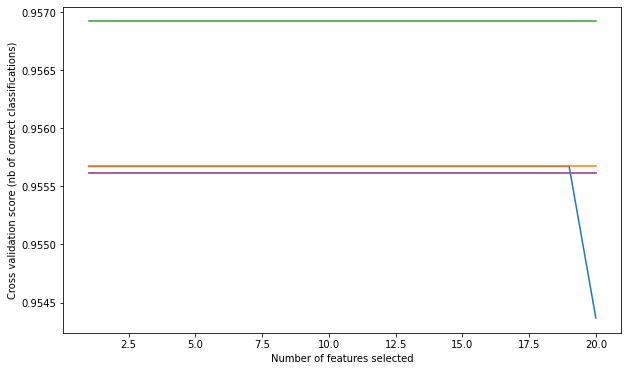

In [69]:
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=5, scoring='accuracy')
rfecv = rfecv.fit(X_train, y_train)

selected_features = list(X_train.columns[rfecv.support_])

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % selected_features)

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Train/Test split results:
LogisticRegression accuracy is 0.937
LogisticRegression log_loss is 0.229
LogisticRegression auc is 0.579


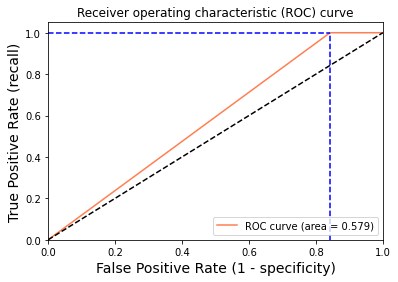

Using a threshold of 0.050 guarantees a sensitivity of 1.000 and a specificity of 0.158, i.e. a false positive rate of 84.22%.


In [70]:
X_logreg = df[selected_features]
X_train_logregr, X_test_logregr, y_train_logregr, y_test_logregr = train_test_split(X_logreg, y, test_size = 0.25, random_state=42) # уже с отобранными признаками
# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_scaled_logregr = scaler.fit_transform(X_train_logregr)
# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_scaled_logregr = scaler.transform(X_test_logregr)
logreg = LogisticRegression()
logreg.fit(X_train_scaled_logregr, y_train_logregr)
y_pred = logreg.predict(X_test_scaled_logregr)
y_pred_proba = logreg.predict_proba(X_test_scaled_logregr)[:, 1]  # предсказываем вероятность по классам
[fpr, tpr, thr] = roc_curve(y_test_logregr, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test_logregr, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test_logregr, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # индекс первого threshold с tpr > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

In [71]:
scores_accuracy = cross_val_score(lr, X_train_scaled_logregr, y_train_logregr, cv=5, scoring='accuracy')
scores_log_loss = cross_val_score(lr, X_train_scaled_logregr, y_train_logregr, cv=5, scoring='neg_log_loss')
scores_auc = cross_val_score(lr, X_train_scaled_logregr, y_train_logregr, cv=5, scoring='roc_auc')
print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average accuracy is 0.956
LogisticRegression average log_loss is 0.177
LogisticRegression average auc is 0.562


Подбор гиперпараметров с помощью GridSearchCV + multiple scorers

Обучаем модель с CV и ищем по сетке гиперпараметр C (чем меньше C тем больше регуляризация).

best estimator: LogisticRegression(C=1e-05)
best params: {'C': 1e-05}
best score: 0.9558978216985917


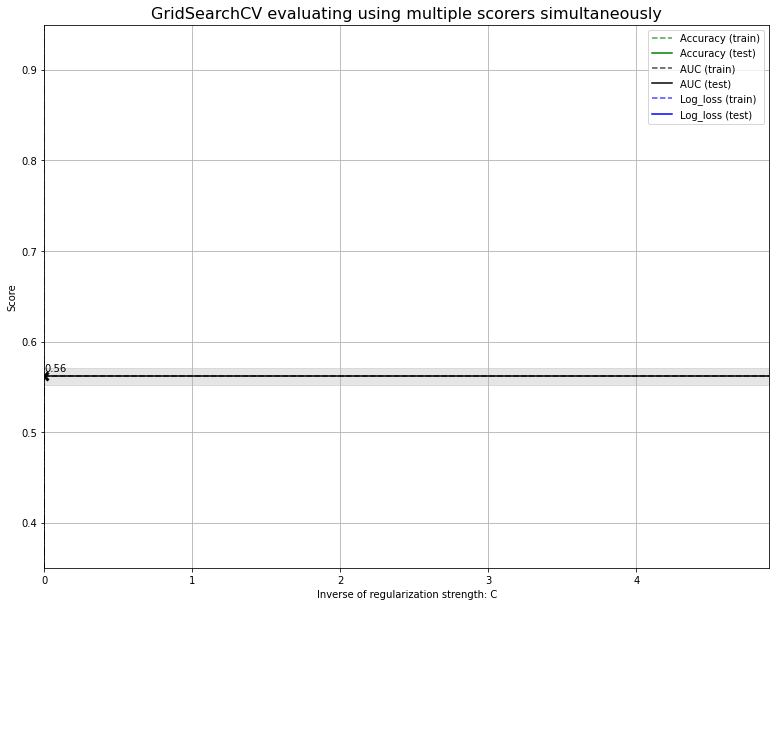

In [72]:
param_grid = {'C': np.arange(1e-05, 5, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=5, refit='Accuracy')

gs.fit(X_train_scaled_logregr, y_train_logregr)
results = gs.cv_results_

print('='*20)
print("best estimator: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)

plt.figure(figsize=(13, 10))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)

plt.xlabel("Inverse of regularization strength: C")
plt.ylabel("Score")
plt.grid()

ax = plt.gca()
ax.set_xlim(0, param_grid['C'].max()) 
ax.set_ylim(0.35, 0.95)

X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

GridSearchCV + multiple scorers + RepeatedStratifiedKFold + pipeline
Поиск по сетке с помощью CV, повторяющийся несколько раз, с масштабированием и различными scorers. StratifiedKFold позволяет разделять выборки с сохранением соотношения объектов каждого класса (стратифицированно).

In [73]:
model_accuracies = {}  # сюда будем сохранять качество натренированных моделей

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

C = np.arange(1e-05, 5, 0.1)

scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

log_reg = LogisticRegression(random_state=11)

std_scale = StandardScaler()

n_folds=5
n_repeats=5

rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=42)

log_clf_pipe = Pipeline(steps=[('scale',std_scale), ('clf',log_reg)])

log_clf = GridSearchCV(estimator=log_clf_pipe, cv=rskfold,
              scoring=scoring, return_train_score=True,
              param_grid=dict(clf__C=C), refit='Accuracy')

log_clf.fit(X_train_logregr, y_train_logregr)
results = log_clf.cv_results_


print('='*80)
print("best estimator: " + str(log_clf.best_estimator_))
print("best params: " + str(log_clf.best_params_))
print('best score:', log_clf.best_score_)
model_accuracies['Logistic Regression'] = log_clf.score(X_test_logregr, y_test_logregr)
print("test score:", model_accuracies['Logistic Regression'])
#print("test score:", accuracy_score(y_test_logregr, log_clf.best_estimator_.predict(X_test_logregr))) # другой способ
print('='*80)

best estimator: Pipeline(steps=[('scale', StandardScaler()),
                ('clf', LogisticRegression(C=1e-05, random_state=11))])
best params: {'clf__C': 1e-05}
best score: 0.9558978216985916
test score: 0.9374021909233177


In [75]:
print("Accuracy of Logistic Regression: {:.4f}".format(model_accuracies['Logistic Regression']))

Accuracy of Logistic Regression: 0.9374


## K-Nearest Neighbour (KNN) Classification

In [76]:
knn = KNeighborsClassifier(n_neighbors = 1)  # n_neighbors means k
knn.fit(X_train_scaled, y_train)
prediction = knn.predict(X_test_scaled)

print("{} NN Score: {:.4f}".format(3, knn.score(X_test_scaled, y_test)))

3 NN Score: 0.9163


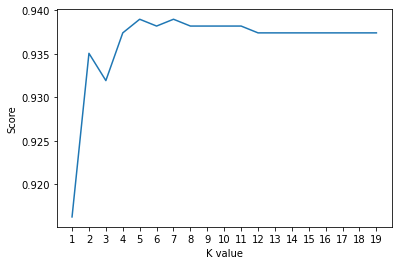

Maximum KNN Score is 0.9390


In [77]:
scoreList = []
for i in range(1, 20):
    knn2 = KNeighborsClassifier(n_neighbors = i)
    knn2.fit(X_train_scaled, y_train)
    scoreList.append(knn2.score(X_test_scaled, y_test))
    
plt.plot(range(1, 20), scoreList)
plt.xticks(np.arange(1, 20))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)
accuracies['KNN'] = acc
print("Maximum KNN Score is {:.4f}".format(acc))

## Support Vector Machine (SVM)

In [78]:
svm = SVC(random_state = 12)
svm.fit(X_train_scaled, y_train)

acc = svm.score(X_test_scaled, y_test)
accuracies['SVM'] = acc
print("Test Accuracy of SVM Algorithm: {:.4f}".format(acc))

Test Accuracy of SVM Algorithm: 0.9374


## Naive Bayes Algorithm

In [79]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

acc = nb.score(X_test_scaled, y_test)
accuracies['Naive Bayes'] = acc
print("Accuracy of Naive Bayes: {:.4f}".format(acc))

Accuracy of Naive Bayes: 0.3412


## Decision Tree Algorithm

In [80]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

acc = dtc.score(X_test, y_test)
accuracies['Decision Tree'] = acc
print("Decision Tree Test Accuracy {:.4f}".format(acc))

Decision Tree Test Accuracy 0.9006


## Comparing Models

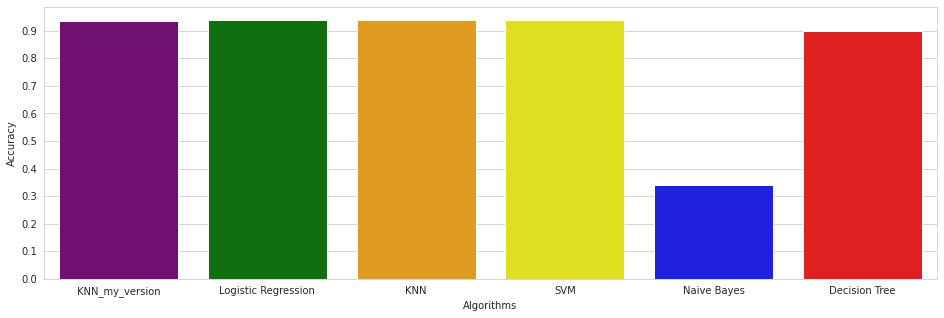

In [81]:
colors = ["purple", "green", "orange", "yellow", "blue", "red"]

sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

## Confusion Matrix

In [82]:
# Predicted values
y_head_lr = lr.predict(X_test_scaled)
knn3 = KNeighborsClassifier(n_neighbors = 1)
knn3.fit(X_train_scaled, y_train)
y_head_knn = knn3.predict(X_test_scaled)
y_head_svm = svm.predict(X_test_scaled)
y_head_nb = nb.predict(X_test_scaled)
y_head_dtc = dtc.predict(X_test)

In [83]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, y_head_lr)
cm_knn = confusion_matrix(y_test, y_head_knn)
cm_svm = confusion_matrix(y_test, y_head_svm)
cm_nb = confusion_matrix(y_test, y_head_nb)
cm_dtc = confusion_matrix(y_test, y_head_dtc)

In [84]:
cm = [cm_lr, cm_knn, cm_svm, cm_nb, cm_dtc]

In [85]:
names = ["Logistic Regression Confusion Matrix", "K Nearest Neighbors Confusion Matrix", "Support Vector Machine Confusion Matrix",
         "Naive Bayes Confusion Matrix", "Decision Tree Classifier Confusion Matrix"]

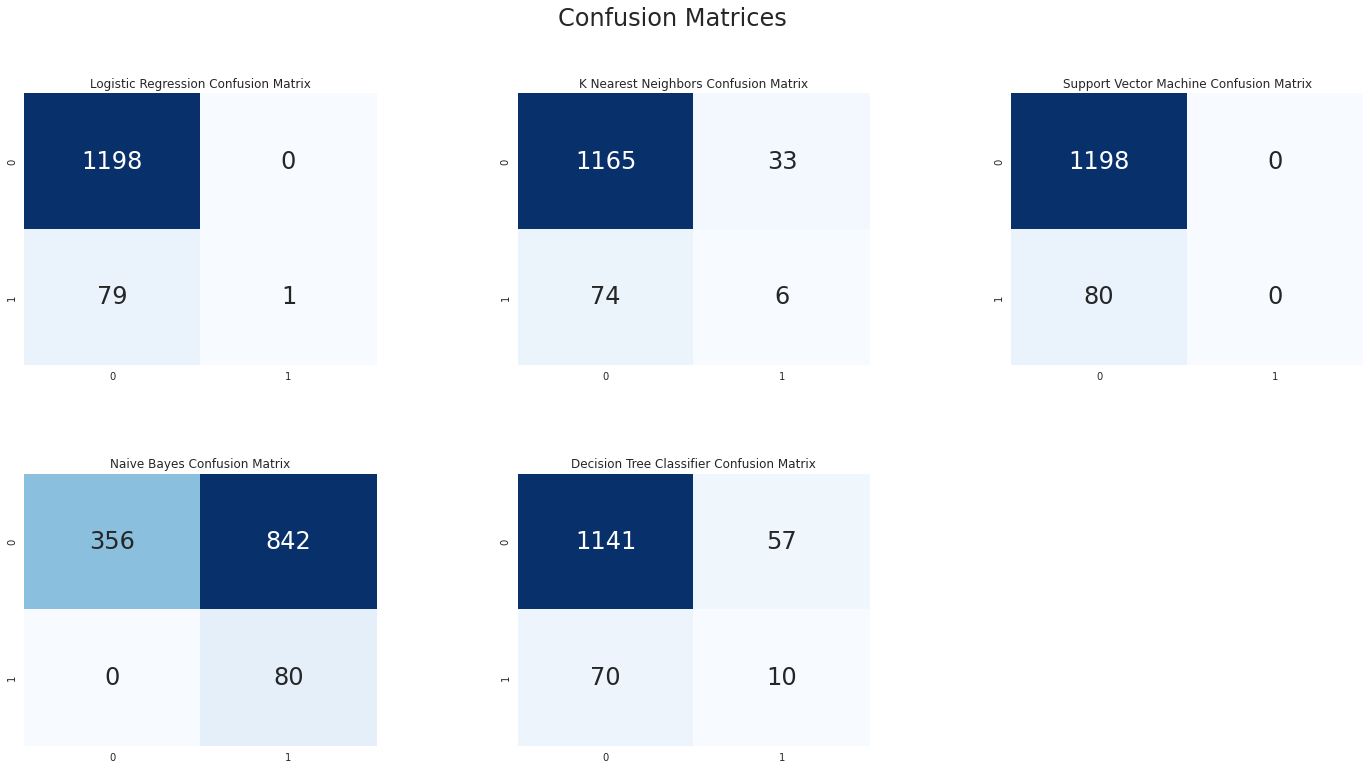

In [86]:
plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(2,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,2)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,3)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,4)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,5)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

Посчитаем FPR, TPR по каждой модели

In [87]:
i=0
for c in cm:
  TN = c[0][0]
  FN = c[1][0]
  TP = c[1][1]
  FP = c[0][1]

  TPR = TP/(TP+FN)
  FPR = FP/(FP+TN)
  TNR = TN/(FP+TN)
  print(names[i])
  i += 1
  print(TPR, FPR, TNR)

Logistic Regression Confusion Matrix
0.0125 0.0 1.0
K Nearest Neighbors Confusion Matrix
0.075 0.027545909849749584 0.9724540901502504
Support Vector Machine Confusion Matrix
0.0 0.0 1.0
Naive Bayes Confusion Matrix
1.0 0.7028380634390651 0.29716193656093487
Decision Tree Classifier Confusion Matrix
0.125 0.04757929883138564 0.9524207011686143


По имеющимся данным, можно сделать вывод, что самой опасной ошибкой для определения наличия сердечно-сосудистых заболевнаий будет ошибка I рода, т.е. признать фактически больного человека здоровым. С этой точки зрения, наилучший результат для прогнозирования итогового результата показал алгоритм Наивный Байес. У него отсутствуют ложноотрицательные результаты. Однако наравне с этим, ошибка II рода имеет гигантское значение, т.е. действительно здоровые люди получат отметку о наличии заболевания что, конечно же, отрицательно влияет на выбор этой модели в качестве решающей. Этот алгоритм обладает низким значением accuracy (правильности).  На втором месте по качеству полученных результатов выходят алгоритмы KNN, Логистическая регрессия и Метод опорных векторов, которые имеют одинаково высокую долю правильности, примерно одинаковое количество ошибок I рода. Однако, у методов Логистической регрессии и опорных векторов отсутствуют ошибки II рода, поэтому их можно назначить наиболее удачно решающими данную задачу.



In [113]:
def log_loss_and_grad(w, X, target):
    m = X.shape[0]
    y=(2*target-1)
    score=np.dot(X, w.T).flatten()
    
    # Рассчёт log_loss
    loss = np.sum(np.log(1+np.exp(-y*score)))/m 
    
    # Рассчёт градиента
    Z=-y/(m*(1+np.exp(y*score)))
    grad=Z[np.newaxis, :].dot(X)
    return loss, grad


def optimize(w, X, y, n_iterations, eta):
    #     потери будем записывать в список для отображения в виде графика
    losses = []
    for i in range(n_iterations):        
        loss, grad = log_loss_and_grad(w, X, y)
        w = w - eta * grad
        losses.append(loss)
        
    return w, losses

def predict(w, X):
    y_predicted = np.zeros(X.shape[0])  
    score=np.dot(X, w.T).flatten()
    Prob = 1/(1+np.exp(-score))
    
    #     За порог отнесения к тому или иному классу примем вероятность 0.5
    y_predicted[Prob>0.5]=1
    y_predicted[Prob<=0.5]=0
        
    return y_predicted

In [114]:
w0 = np.zeros((1, X_train.shape[1]))

n_iterations = 1000
eta = 0.0001

w, losses = optimize(w0, X_train, y_train, n_iterations, eta)

y_predicted_test = predict(w, X_test)
y_predicted_train = predict(w, X_train)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test)*100.0)

print(f"Итоговый вектор весов w: {w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[ 1.06973041e-02  6.71449730e-04  5.64958116e-04 -1.60875305e-02
  -5.70510114e-02 -1.64623029e-03 -9.29409522e-04 -2.06148281e-03
  -5.14157008e-04 -2.84482986e-04 -3.98561001e-05 -1.25567827e-03
   8.41155035e-05 -1.07973797e-03 -1.42152486e-03 -1.15411496e-03
  -1.43900021e-03  1.88820137e-06 -9.04927381e-04 -2.33600429e-04]]
Точность на обучающей выборке: 95.590
Точность на тестовой выборке: 93.740


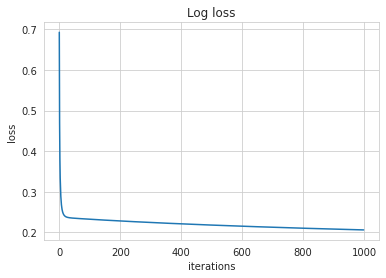

In [115]:
plt.title('Log loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.plot(range(len(losses)), losses)

Из графика видно, что оптимальное значение loss достигается на 900 итерации.

In [116]:
accuracies['Logistic_regression_my_version'] = test_accuracy/100

Comparing Models

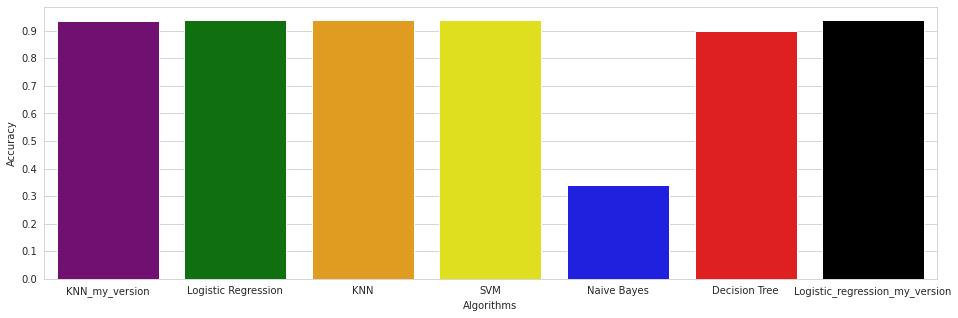

In [117]:
colors = ["purple", "green", "orange", "yellow", "blue", "red", "black"]

sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

Последняя модель логистической регрессии в самописной реализации показала результаты наравне с пакетной реализацией, поэтому выводы остаются прежними (см. под предыдущим графиком Comparing Models)